In [4]:
import mrcfile
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from contrasttransferfunction.spectrumhelpers import radial_average

(12, 1022, 1440)
int16
8845.370699359462


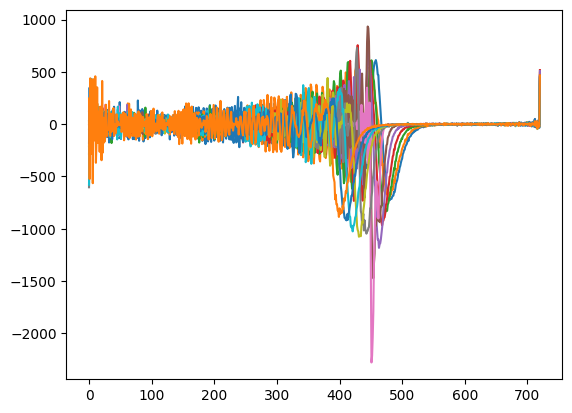

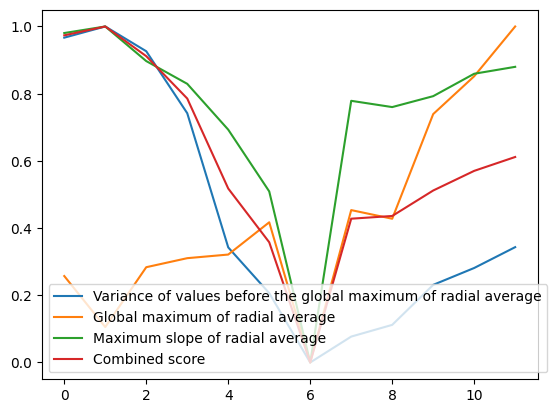

In [37]:
with mrcfile.open("/data/elferich/CryoTEM/Johannes_20230808/Johannes_20230808/beam_frings.mrc","r") as mrc:
    mrc_defocus_range = mrc.data

print(mrc_defocus_range.shape)
print(mrc_defocus_range.dtype)
print(mrc_defocus_range.mean())



variance_before_maximum = []
global_maximum = []
maximum_slope = []
for slice in mrc_defocus_range:
    # Crop out largest possbile square from the center of slice
    # Get the dimensions of the array
    rows, cols = slice.shape

    # Calculate the size of the center square
    size = min(rows, cols)

    # Calculate the starting indices for the slice
    start_row = (rows - size) // 2
    start_col = (cols - size) // 2

    # Slice the array to get the center square
    center = slice[start_row:start_row+size, start_col:start_col+size]
    ra = radial_average(center)
    # Get all values before the global maximum
    variance_before_maximum.append(ra[:ra.argmax()].var())
    global_maximum.append(ra.max())
    maximum_slope.append(np.diff(ra).__abs__().max())
    plt.plot(np.diff(ra), label="Maximum slope of radial average")
plt.show()

variance_before_maximum = np.array(variance_before_maximum)
global_maximum = np.array(global_maximum)
variance_before_maximum -= variance_before_maximum.min()
variance_before_maximum /= variance_before_maximum.max()
global_maximum -= global_maximum.min()
global_maximum /= global_maximum.max()
maximum_slope = np.array(maximum_slope)
maximum_slope -= maximum_slope.min()
maximum_slope /= maximum_slope.max()
maximum_slope = 1 - maximum_slope
combined_score = (variance_before_maximum + maximum_slope)/2.0
plt.plot(variance_before_maximum, label="Variance of values before the global maximum of radial average")
plt.plot(global_maximum, label="Global maximum of radial average")
plt.plot(maximum_slope, label="Maximum slope of radial average")
plt.plot(combined_score, label="Combined score")
plt.legend()



In [45]:
best_slice = mrc_defocus_range[6]

# Get the average value in the center of the image
center = int(best_slice.shape[0]/2)
center_value = np.mean(best_slice[center-50:center+50,center-50:center+50])
bin_sqaured = 16 # Should be 16 because bin set to 4
exposure_time = 3 # Maybe set exposure time to 1 seconds for this methos
counts_per_electron = 32 # Get from ReportCountScaling
center_value / bin_sqaured / exposure_time / counts_per_electron

12.7778716796875

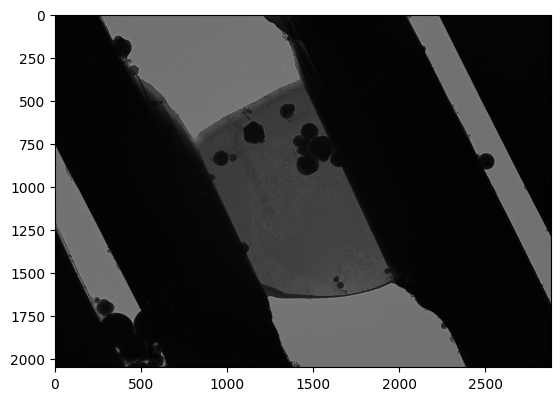

In [5]:
with mrcfile.open("/data/elferich/CryoTEM/Johannes_20230808/Johannes_20230808/cd34p_C_g1/cd34p_C_g1_views.mrc","r") as mrc:
    view_images = mrc.data

plt.imshow(view_images[4], cmap='gray')

In [6]:
rows, cols = view_images[4].shape

# Calculate the size of the center square
size = min(rows, cols)

# Calculate the starting indices for the slice
start_row = (rows - size) // 2
start_col = (cols - size) // 2

# Slice the array to get the center square
center = view_images[4][start_row:start_row+size, start_col:start_col+size]
ps = np.abs(np.fft.fftshift(np.fft.fft2(center)))

In [39]:
def cosine_highpass(spectrum: np.ndarray, pixel_size_angstroms: float = 1.0) -> np.ndarray:
    mask_radius = float(spectrum.shape[0]) / 5
    mask_edge = float(spectrum.shape[0]) / 5
    
    #return spectrum
    mask_radius = mask_radius - mask_edge * 0.5
    mask_radius_plus_edge = mask_radius + mask_edge

    distance_center = distance_from_center_array(spectrum.shape[0])

    cos_filter = np.zeros_like(spectrum)
    outside_mask = distance_center >= mask_radius
    cos_filter[outside_mask] = 1 - (
        (1 + np.cos(np.pi * (distance_center[outside_mask] - mask_radius) / mask_edge)) / 2.0
    )
    cos_filter[distance_center >= mask_radius_plus_edge] = 1.0

    return spectrum * cos_filter

In [40]:
from contrasttransferfunction import CtfFit
from contrasttransferfunction.spectrumhelpers import ctffind_preproc, downscale_spectrum, adjust_central_cross, subtract_baseline, distance_from_center_array, radial_average
pps = downscale_spectrum(ps,512)
pps = adjust_central_cross(pps)
pps = subtract_baseline(pps)
pps = cosine_highpass(pps,76.8)

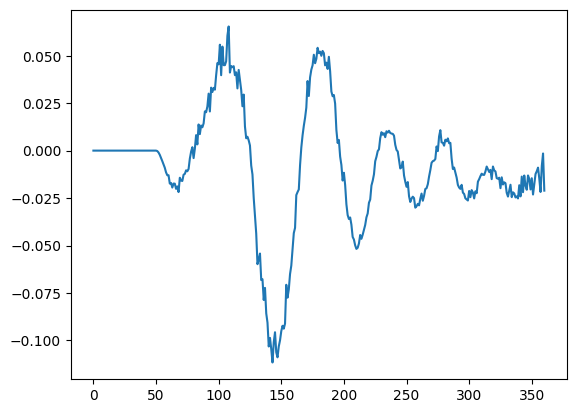

In [41]:
plt.plot(radial_average(pps))

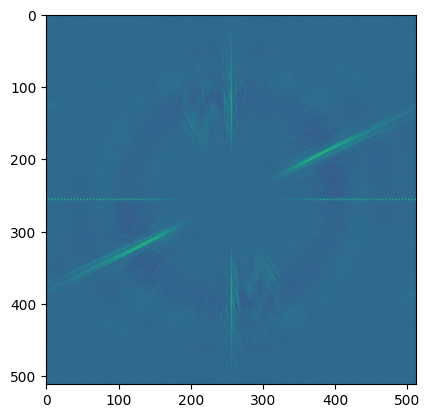

In [42]:
plt.imshow(pps)

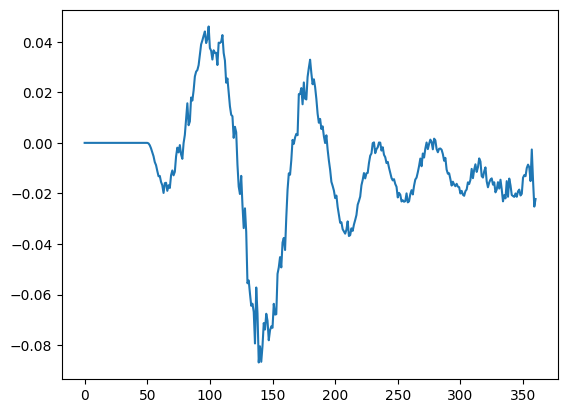

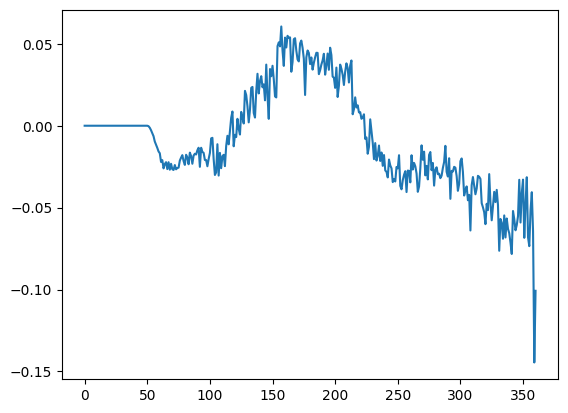

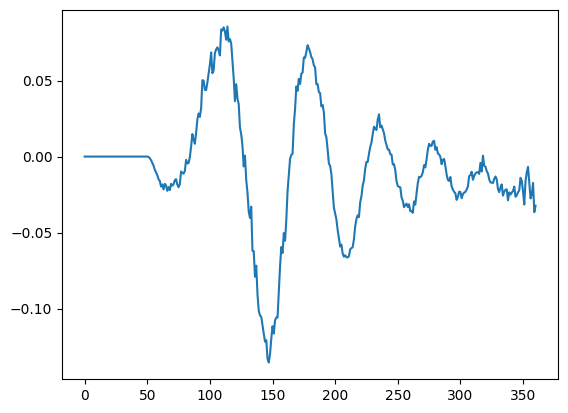

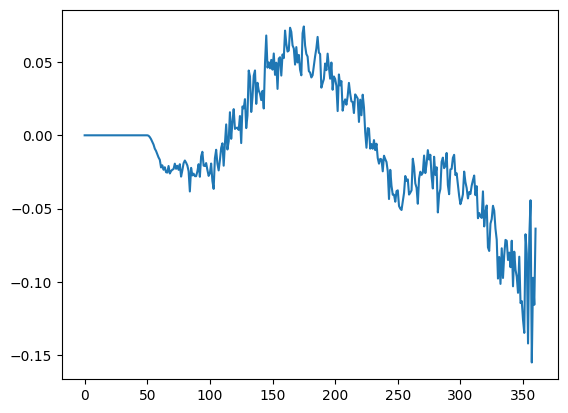

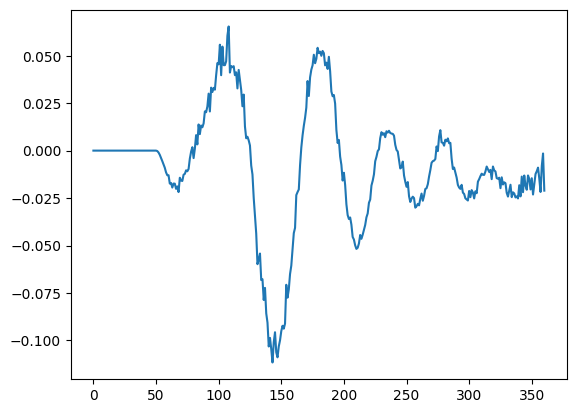

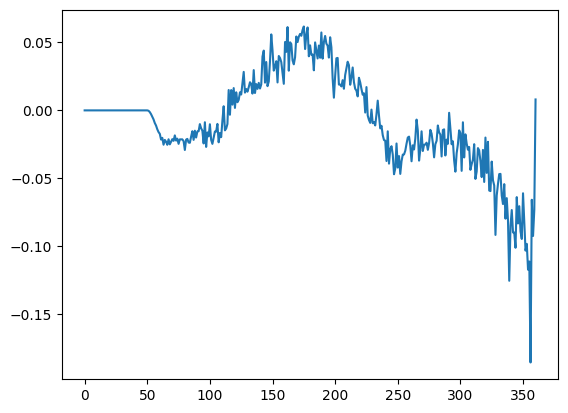

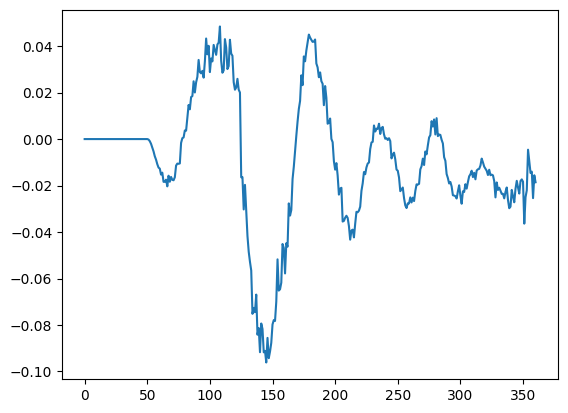

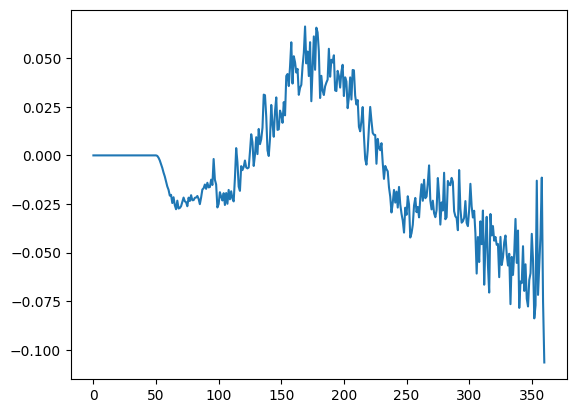

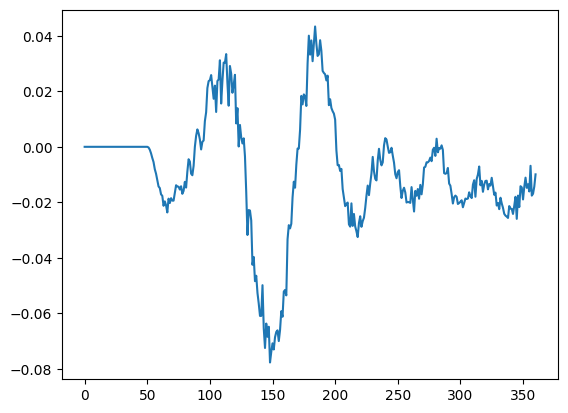

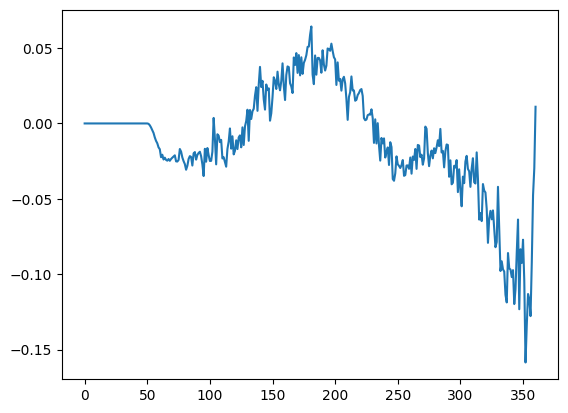

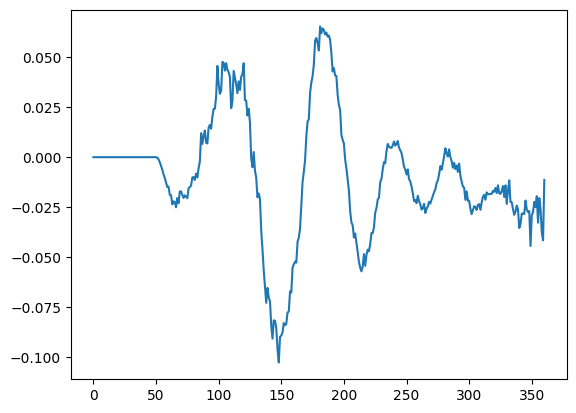

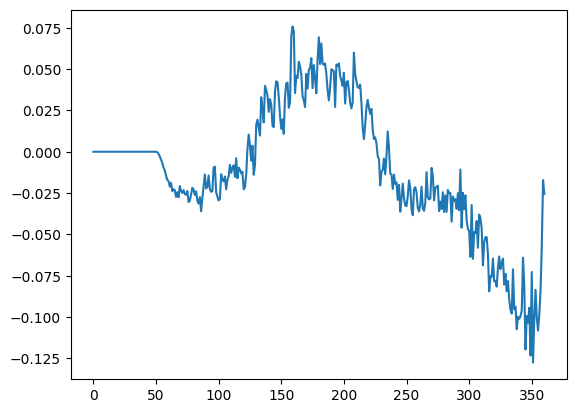

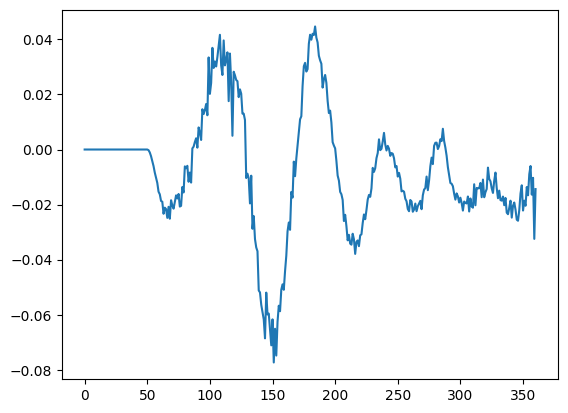

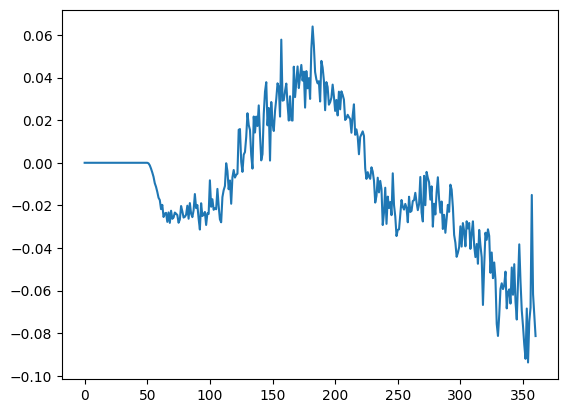

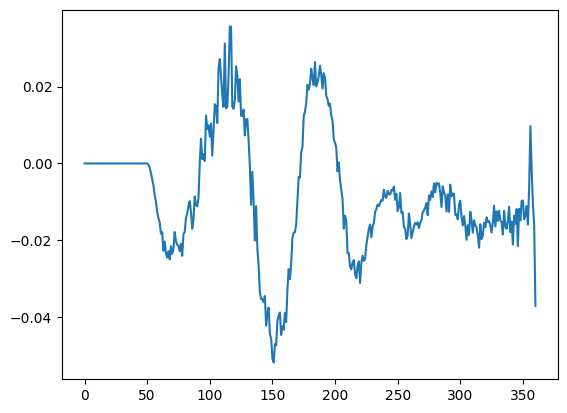

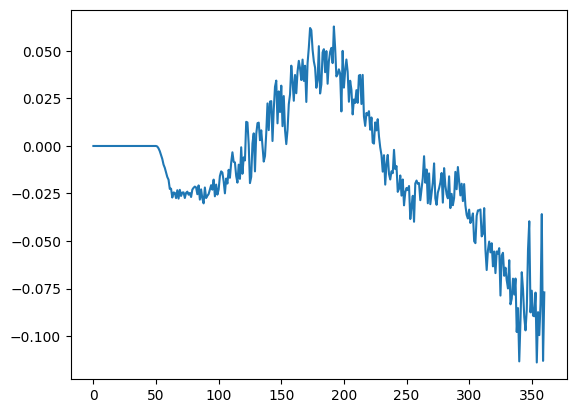

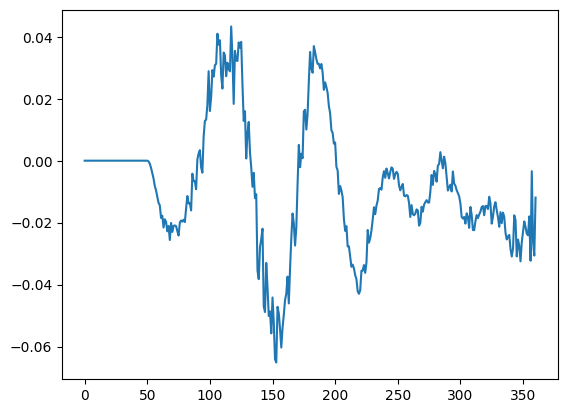

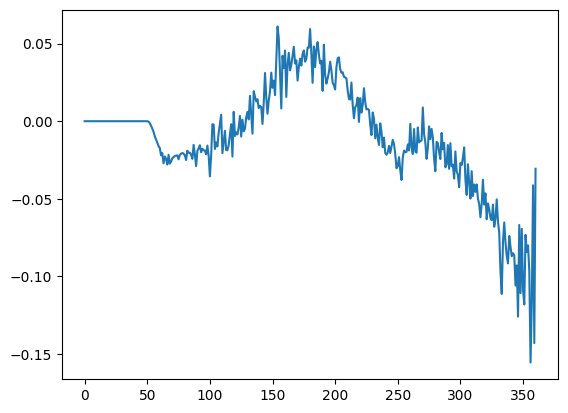

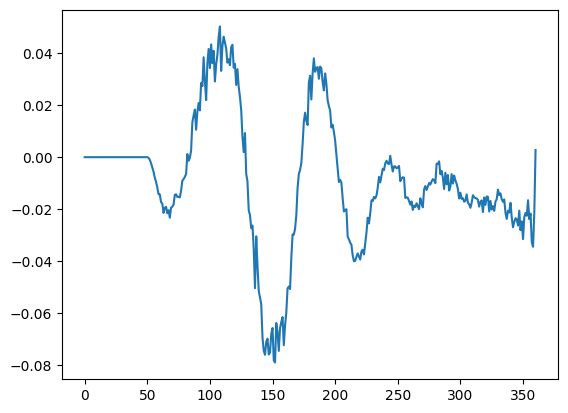

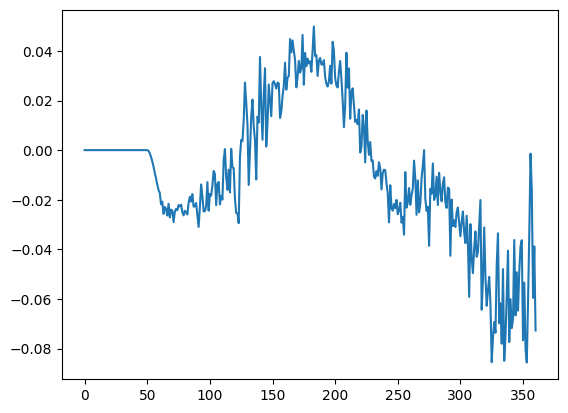

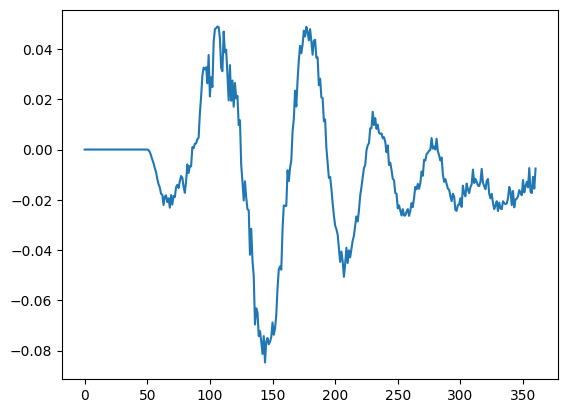

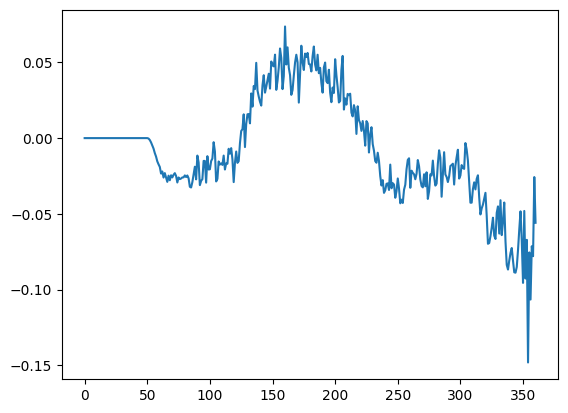

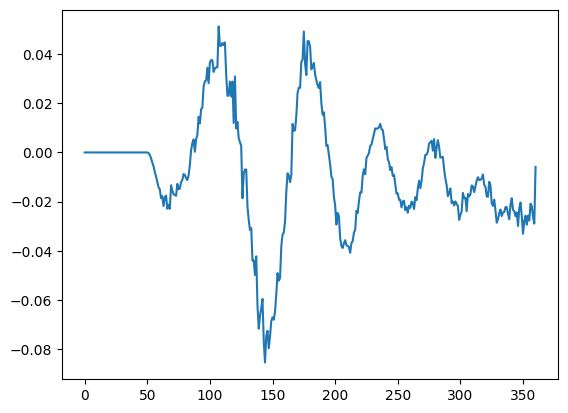

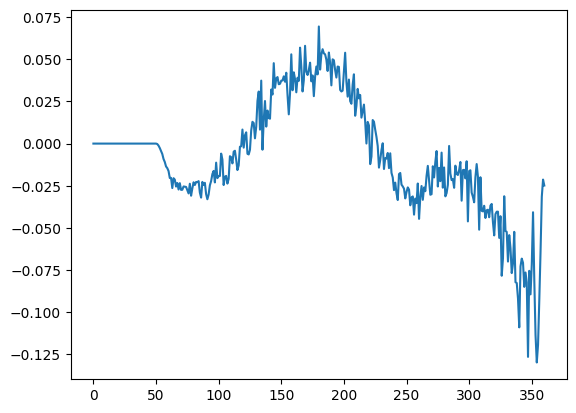

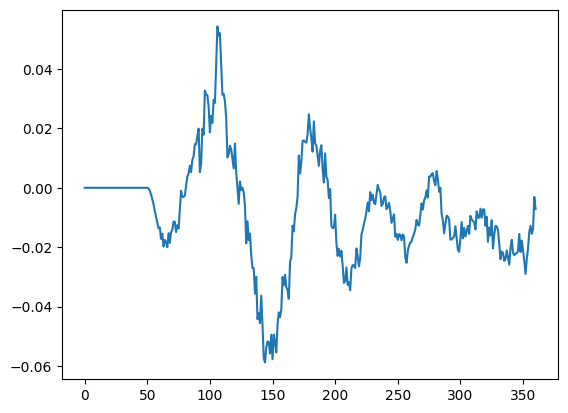

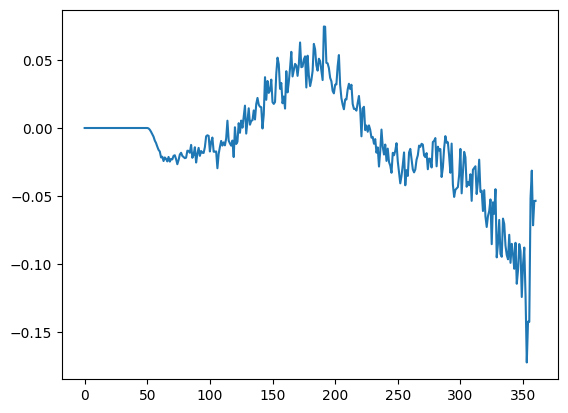

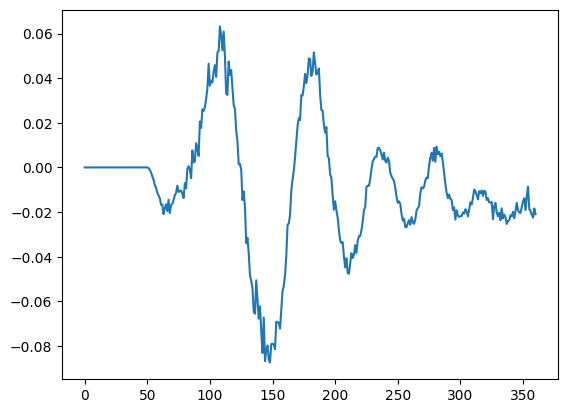

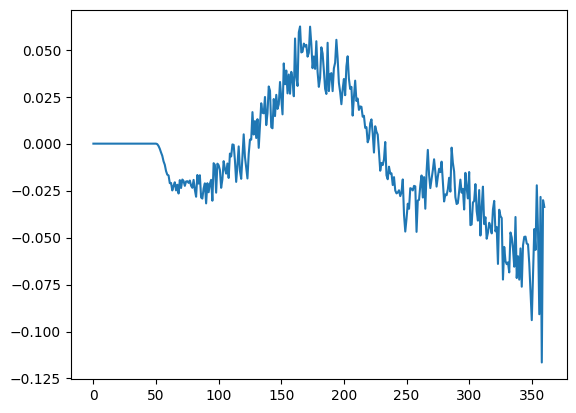

In [43]:
for slice in view_images:
    rows, cols = slice.shape

    # Calculate the size of the center square
    size = min(rows, cols)

    # Calculate the starting indices for the slice
    start_row = (rows - size) // 2
    start_col = (cols - size) // 2

    # Slice the array to get the center square
    center = slice[start_row:start_row+size, start_col:start_col+size]
    ps = np.abs(np.fft.fftshift(np.fft.fft2(center)))

    pps = downscale_spectrum(ps,512)
    pps = adjust_central_cross(pps)
    pps = subtract_baseline(pps)
    pps = cosine_highpass(pps,76.8)
    plt.plot(radial_average(pps))
    plt.show()